In [1]:
!pip install numpy pandas matplotlib scikit-learn &> /dev/null

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
class NeuralNetwork:
    def __init__(self, input_n, output_n, activation="sigmoid"):
        self.input_n = input_n
        self.output_n = output_n
        
        self.hiddenLayerN = 30
        
        # Input to layer 1
        self.w1 = np.random.randn(input_n, self.hiddenLayerN)
        self.b1 = np.random.randn(self.hiddenLayerN)
        
        # Layer 1 to output
        self.w2 = np.random.randn(self.hiddenLayerN, output_n)
        self.b2 = np.random.randn(output_n)
        
        # activation function
        self.activation = None
        self.activation_derivative = None
        
        self.setActivation(activation)
        
    def setActivation(self, activation):
        if activation == "sigmoid":
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == "relu":
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == "tanh":
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise Exception("Invalid activation function")
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2
        
    def forwardPass(self, X):
        self.t1 = X @ self.w1 + self.b1
        self.t2 = self.activation(self.t1)
        self.t3 = self.t2 @ self.w2 + self.b2
        return self.activation(self.t3)
    
    def backwardPass(self, X, y, output, lr):
        error = y - output
        delta = error * self.activation_derivative(output)
        
        hidden_layer_error = delta @ self.w2.T
        hidden_layer_delta = hidden_layer_error * self.activation_derivative(self.t2)
        
        self.w2 += self.t2.T @ delta * lr
        self.b2 += np.sum(delta, axis=0) * lr
        self.w1 += X.T @ hidden_layer_delta * lr
        self.b1 += np.sum(hidden_layer_delta, axis=0) * lr
    
    def loss(self, X, Y):
        t = self.forwardPass(X)
        return np.sum((t - Y) ** 2)
    
    def lossDerivativeWRTB2(self, X, Y):
        return 2 * (self.activation(self.t3) - Y) * self.activation_derivative(self.t3)

    def lossDerivativeWRTW2(self, X, Y):
        return self.t2.T @ self.lossDerivativeWRTB2(X, Y)

    def lossDerivativeWRTB1(self, X, Y):
        return (self.lossDerivativeWRTB2(X, Y) @ self.w2.T) * self.activation_derivative(self.t1)

    def lossDerivativeWRTW1(self, X, Y):
        return X.T @ self.lossDerivativeWRTB1(X, Y)
    
    def fit(self, X, y, epochs=1000, lr=0.01, plot=False):
        losses = []
        for i in range(epochs):
            output = self.forwardPass(X)
            self.backwardPass(X, y, output, lr)
            losses.append(self.loss(X, y))

        if plot:
            plt.plot(losses)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
            
    def accuracy(self, X, y):
        return np.mean(np.argmax(self.forwardPass(X), axis=1) == np.argmax(y, axis=1))


In [4]:
X, y = load_digits(return_X_y=True)
y = y.reshape(-1, 1)
print(X.shape, y.shape)

(1797, 64) (1797, 1)


### Visualizing the data

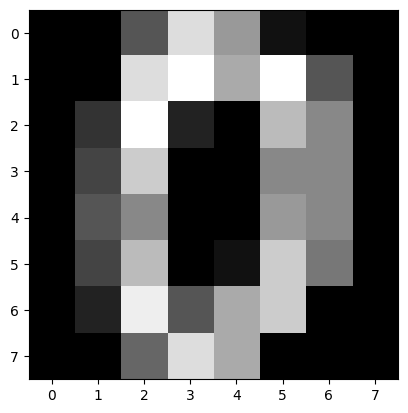

In [5]:
plt.imshow(X[0].reshape(8, 8), cmap="gray")

### Data Preprocessing

In [6]:
# Shuffle the data
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Use standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One hot encode y
def oneHotEncode(y):
    y_ = np.zeros((y.shape[0], np.unique(y).shape[0]))
    for i in range(y.shape[0]):
        y_[i][y[i]] = 1
    return y_

y_one_hot = oneHotEncode(y)
y_one_hot

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1437, 64) (1437, 10) (360, 64) (360, 10)


### Training and Test

### 1. Sigmoid

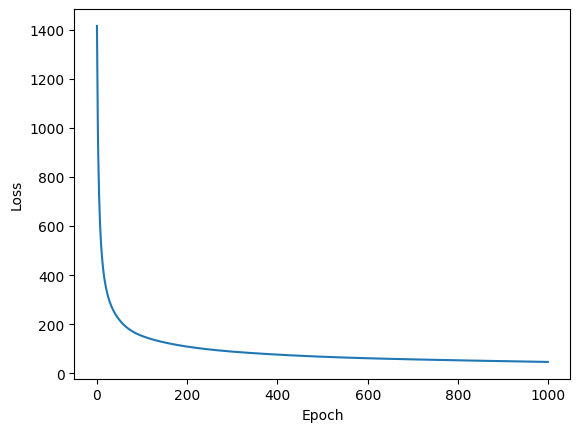

Train accuracy: 0.99
Test accuracy: 0.93


In [7]:
sigmoid_nn = NeuralNetwork(X.shape[1], y_one_hot.shape[1], activation="sigmoid")
sigmoid_nn.fit(X_train, y_train, epochs=1000, lr=0.005, plot=True)
print("Train accuracy:", np.round(sigmoid_nn.accuracy(X_train, y_train), 2))
print("Test accuracy:", np.round(sigmoid_nn.accuracy(X_test, y_test), 2))

#### Observations
1. The NN with sigmoid performs poorly when learning rate is greater than 0.01. It does well when learning rate is less than 0.01.
2. With epochs=10000 and lr=0.01, the NN with sigmoid performs similar to the NN when lr=0.005 and epochs=1000. So, I am using lr=0.005 and epochs=1000 as it has lower training time.

### 2. ReLU

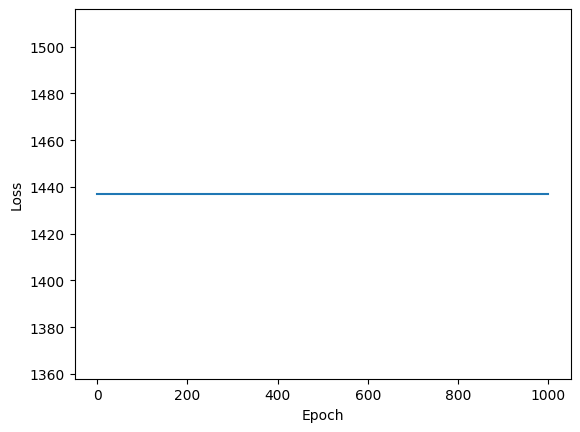

Train accuracy: 0.1
Test accuracy: 0.09


In [8]:
relu_nn = NeuralNetwork(X.shape[1], y_one_hot.shape[1], activation="relu")
relu_nn.fit(X_train, y_train, epochs=1000, lr=0.001, plot=True)
print("Train accuracy:", np.round(relu_nn.accuracy(X_train, y_train), 2))
print("Test accuracy:", np.round(relu_nn.accuracy(X_test, y_test), 2))

#### Observations
1. The NN with relu performs poorly regardless of the choice of learning rate and epochs.

### 3. Tanh

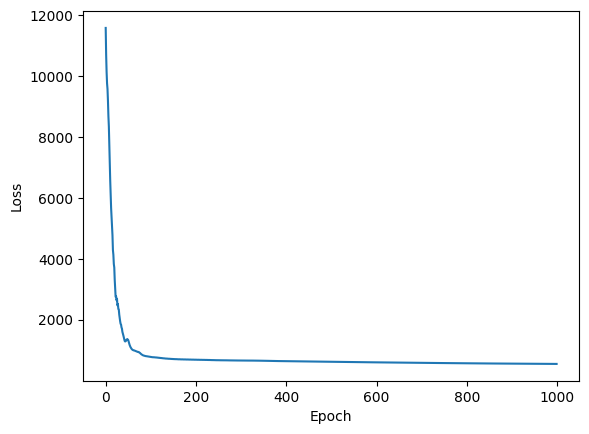

Train accuracy: 0.95
Test accuracy: 0.91


In [9]:
tanh_nn = NeuralNetwork(X.shape[1], y_one_hot.shape[1], activation="tanh")
tanh_nn.fit(X_train, y_train, epochs=1000, lr=0.001, plot=True)
print("Train accuracy:", np.round(tanh_nn.accuracy(X_train, y_train), 2))
print("Test accuracy:", np.round(tanh_nn.accuracy(X_test, y_test), 2))

#### Observations
1. The NN with tanh gives similar results using same hyperparameters as sigmoid.
2. Overall sigmoid performs better than tanh and relu. Sometimes, tanh performs better than sigmoid.